# 神经网络之Dropout

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os 
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd, sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.19.2
pandas 0.23.0
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist #手写数据集
# 输出训练集（数据、标签）、测试集（数据、标签）
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 把数据划分为训练集、测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]

y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

添加dropout

In [4]:
# 加入批归一化
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))

# 激活函数selu -> 自带归一化的函数，一定程度上缓解梯度消失问题
# 添加20层的神经网络
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu")) #添加全连接层

# 神经网络的最后一层添加dropout
# AlphaDropout更加强大的dropout, 1、均值和方差不变 2、归一化的性质也不变，一般使用AlphaDropout
model.add(keras.layers.AlphaDropout(rate = 0.5)) # 随机屏蔽的单元比例，一般设置为0.5
# model.add(keras.layers.Dropout(rate = 0.5))



model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [5]:
# 输出模型的网络层次
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
# Tensorboard, earlystopping, ModelCheckpoint

# 把这个路径用包装一下
logdir = os.path.join("dnn-selu-dropout-callbacks")
print(logdir)
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),# 保存效果最好的模型
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

# 添加回调函数
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

dnn-selu-dropout-callbacks
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 189us/sample - loss: 0.6947 - accuracy: 0.7655 - val_loss: 0.6237 - val_accuracy: 0.8478
Epoch 2/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.4574 - accuracy: 0.8415 - val_loss: 0.6154 - val_accuracy: 0.8552
Epoch 3/10
55000/55000 [==============================] - 8s 141us/sample - loss: 0.4082 - accuracy: 0.8584 - val_loss: 0.5768 - val_accuracy: 0.8644
Epoch 4/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3767 - accuracy: 0.8681 - val_loss: 0.4431 - val_accuracy: 0.8698
Epoch 5/10
55000/55000 [==============================] - 8s 139us/sample - loss: 0.3547 - accuracy: 0.8746 - val_loss: 0.4942 - val_accuracy: 0.8758
Epoch 6/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.3361 - accuracy: 0.8789 - val_loss: 0.5613 - val_accuracy: 0.8782
Epoch 7/10
55000/55000 

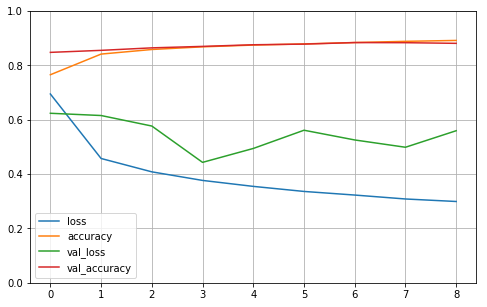

In [7]:
# 打印学习曲线图
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) #设置网格
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [8]:
# 在测试集上进行测试
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6408684496462345, 0.8698]

出现下面的情况原因: 

1、参数众多，训练不充分

2、梯度消失 -> 链式法则 -> 复合函数f(g(x))

3、 批归一化缓解梯度消失

4、selu更好缓解梯度消失

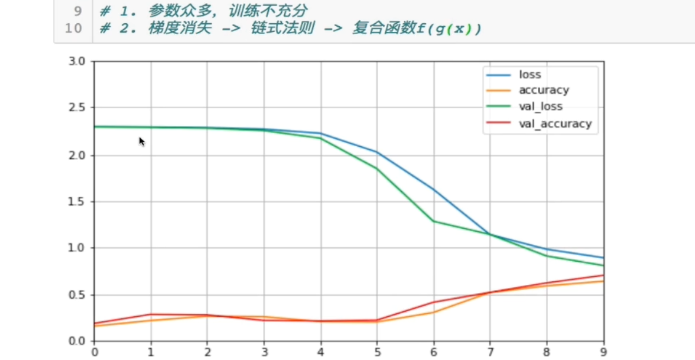

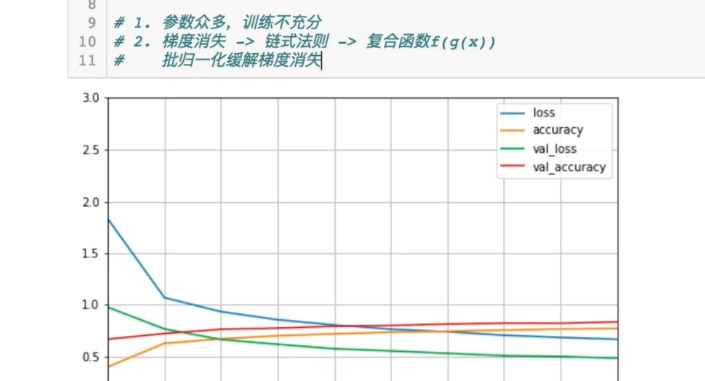